# Problem Synopsis:
In this notebook, the aim is to develop a machine learning model to predict the level of effort (LOE) required to carry out
audit projects. Audit projects come in different shapes and sizes, with different start and end dates. They cover a wide variety of risk clusters and subdivisions of the organization.  Being able to determine what factors determine the factors that influence projects' LOE will enable management to optimize project planning and maximize its risk coverage per cycle.
<br>
<br>
<br>
**The focus in this notebook is to show concpets and techniques related to data processing, converting large text fields into useful columns, and using synthetic data.** And althoigh some modeling is applied, it used to show the impact of synthetic data on model performance.

The models developed in this notebook aim to achieve 2 goals: 1) Predict the required LOE for a given project; and 2) Highlight the parameters that impact project LOE. The second goal is particularly important as it will give management insight into the factors influencing project LOE, empowering them to make smart decisions moving forward.

for this notebook, there are 3 datafiles:
- File 1 (projects): An export from the project planning database. contains the following columns:

| Column Name    | Description |
| :---: | :--- |
| Product Type | The different types of audit products [Audit, Assurance Review, Advisory, Insight Note, Verification Review]. Each product has a different process and audience
| Fiscal Year |	The planned fiscal year for the project
| Legal Entity | The various legal sub-entities within the organization [Main, Insurance, Lending, Investment, Regions, Mediation]
| IO | Stands for Internal Order, The unique identifier for the project
| Ending Q | The revised ending quarter for the project
| BusinessArea | The general business area covered by the project.
| Related Auditable Entities | The specific function within the business area covered by the project
| Indicative Budget | Original LOE estimate for the project at the planning stage
| Starting Q | The planned starting quarter for the project
| Business Application | The list of business applications to be covered by
| Team | The responsible team within the internal audit function. There are 4 teams: CP, OP, IT, REG

- File 2 (AEs): Contains the list of Auditable entities and their mapping to the parent risk clusters
- File 3 (project_effort_duration): Contains the actual duration and effort (LOE) for completed projectsthe project

## Library Imports

In [ ]:
#!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Display Settings

In [ ]:
#manage display setup
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', None)

## Data Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read Data

#Engagement Data excluding LOE and Duration
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Predicting Project Effort/Projects.csv')

#Engagement LOE and Duration
df_metrics = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Predicting Project Effort/project_effort_duration.csv')

#Auditable Entity Mapping to Clusters
df_clusters = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Code Portfolio/Predicting Project Effort/AEs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product Type                475 non-null    object 
 1   Fiscal Year                 475 non-null    object 
 2   Legal Entity                475 non-null    object 
 3   IO                          178 non-null    float64
 4   Ending Quarter              475 non-null    object 
 5   BusinessArea                475 non-null    object 
 6   Related Auditable Entities  475 non-null    object 
 7   Indicative Budget           287 non-null    float64
 8   Starting Quarter            335 non-null    object 
 9   Business Applications       121 non-null    object 
 10  Team                        475 non-null    object 
dtypes: float64(2), object(9)
memory usage: 40.9+ KB


## Data Cleaning and Preparation

The goal in this section is to prepare the data for use in the predictive models. In order to do that, we need to:
- Choose the right combinations of columns and rows
- convert the string values into dummy variables to be be cosumed by the predictive model. Namely, we need to convert the data for Entity, Product Type, Start Quarter, End Quarter, and business area into dummy variables.
- bring the cluster data into the project dataframe using the auditable entity column
- bring the actual effort data into the project dataframe using the IO column

In order to acheive that, we will need to join the different data sources, create the necessary columns, and reshape the data as necessary.

In [ ]:
#Include only Fiscal Years FY21-FY24. Any projects outside of that range are not relevant to this analysis

#get list of FYs in the data
fys = df['Fiscal Year'].value_counts()
fys

,count
Fiscal Year,
FY98,95
FY99,93
FY27,56
FY26,53
FY25,50
FY23,36
FY24,35
FY21,30
FY22,25


In [ ]:
#identify The Fys in scope
fy_scope=['FY23','FY24','FY21','FY22']


#Include only FYs in scope
df = df[df['Fiscal Year'].isin(fy_scope)]
#df.info()

In [ ]:
#Remove Extra Columns

#Specify Columns to Keep
include_cols= ['Product Type', 'Fiscal Year', 'Legal Entity', 'IO', 'Ending Quarter', 'BusinessArea', 'Related Auditable Entities', 'Starting Quarter', 'Team']

#Trncate the dataframe to the selected columns
df = df[include_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Product Type                126 non-null    object 
 1   Fiscal Year                 126 non-null    object 
 2   Legal Entity                126 non-null    object 
 3   IO                          126 non-null    float64
 4   Ending Quarter              126 non-null    object 
 5   BusinessArea                126 non-null    object 
 6   Related Auditable Entities  126 non-null    object 
 7   Starting Quarter            95 non-null     object 
 8   Team                        126 non-null    object 
dtypes: float64(1), object(8)
memory usage: 9.8+ KB


In [ ]:
#Rename columns for easier processing

#create new names:
new_names = ['product_type', 'fy', 'entity', 'io', 'q_end', 'business_area', 'aes', 'q_start', 'team']

df.columns = new_names


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_type   126 non-null    object 
 1   fy             126 non-null    object 
 2   entity         126 non-null    object 
 3   io             126 non-null    float64
 4   q_end          126 non-null    object 
 5   business_area  126 non-null    object 
 6   aes            126 non-null    object 
 7   q_start        95 non-null     object 
 8   team           126 non-null    object 
dtypes: float64(1), object(8)
memory usage: 9.8+ KB


In [ ]:
#re-arrange the dtaframe for readability - change columns order
df = df.iloc[:, [1,2,8,5,3,0,7,4,6]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fy             126 non-null    object 
 1   entity         126 non-null    object 
 2   team           126 non-null    object 
 3   business_area  126 non-null    object 
 4   io             126 non-null    float64
 5   product_type   126 non-null    object 
 6   q_start        95 non-null     object 
 7   q_end          126 non-null    object 
 8   aes            126 non-null    object 
dtypes: float64(1), object(8)
memory usage: 9.8+ KB


## Data Processing and Feature Engineering.
In this section, the datasets are joined and the features are engineered to arrive at meaningful dataset that is conducive to modeling





In [ ]:
#Create ordinal Mapping of risk rating
rating_dict = {'High':4, 'Significant':3, 'Medium':2, 'Low':1}
rating_keys = rating_dict.keys()
rating_values = rating_dict.values()

In [ ]:
#Remove "FY" prefix from Quarter value
df['qst'] = df['q_start'].str.split('-').str[1]
df['qnd'] = df['q_end'].str.split('-').str[1]

In [ ]:
df.drop(labels = ['q_start','q_end'],axis = 1, inplace=True)

In [ ]:
#Convert Aes strings to Lists and Assign risk rating for the engagement

#covert the AE strinf into a list of AEs
df['aes2'] = df['aes'].str.split(r'(?<=\))(?<!\|),')

#Split AE and rating into seperate items in a list
df['aes2'] = [[s.split('|') for s in sublist] for sublist in df['aes2']]

#Remove rating from AEs, use AE ratings per engagement to arrive at the max risk rating for the engagement
df['eng_risk_rating'] = [max([rating_dict[s.pop(1).replace('(','').replace(')','').strip()] for s in sublist]) for sublist in df['aes2']]

#Concatenate the aes lists to reduce dimensionality
df['aes2'] = [np.concatenate(sublist) for sublist in df['aes2']]

#Strip White Space from the AE text
df['aes2'] = [[x.strip() for x in sublist] for sublist in df['aes2']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 0 to 125
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fy               126 non-null    object 
 1   entity           126 non-null    object 
 2   team             126 non-null    object 
 3   business_area    126 non-null    object 
 4   io               126 non-null    float64
 5   product_type     126 non-null    object 
 6   aes              126 non-null    object 
 7   qst              95 non-null     object 
 8   qnd              126 non-null    object 
 9   aes2             126 non-null    object 
 10  eng_risk_rating  126 non-null    int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 11.8+ KB


In [ ]:
df.head(2)

,fy,entity,team,business_area,io,product_type,aes,qst,qnd,aes2,eng_risk_rating
0,FY21,Lending,OP,20. Operations,2104615.0,Assurance Review,LEN-Research Publications | (Significant),Q2,Q2,[LEN-Research Publications],3
1,FY21,Main,IT,50. Information Technology,2104700.0,Assurance Review,"LEN-Manage Data Privacy | (Significant),INV-Manage Data Privacy | (Significant),INS-Manage Data Privacy | (Significant),MAIN-IT Policy, Standards, Compliance | (Medium)",Q2,Q3,"[LEN-Manage Data Privacy, INV-Manage Data Privacy, INS-Manage Data Privacy, MAIN-IT Policy, Standards, Compliance]",3


In [ ]:
#identify and duplications in the metrics dtaframe
duplicates = df_metrics.duplicated(['io'])
df_metrics[duplicates]

,io,loe,duration
20,2103023,238.0,51.0
21,2103023,238.0,51.0
22,2103023,238.0,51.0
102,2109149,101.0,221.0
103,2109149,101.0,221.0
104,2109149,101.0,221.0
105,2109149,101.0,221.0
106,2109149,101.0,221.0
108,2109174,NaN,NaN
109,2109174,NaN,NaN


In [ ]:
#Drop Duplicate Columns in Metrics Dataframe
df_metrics.drop_duplicates(subset='io', inplace=True)

In [ ]:
#Join Metrics and master dataframes to add LOE and Duration to master dataframe

#Unify data type for IO in both dataframes
df['io'].astype('int32')
df_metrics['io'].astype('int32')

#Create a new  Data frame [df3] that include all columns from master dataframe and Metrics
df3 = pd.merge(left = df, right = df_metrics, on = 'io', validate = 'one_to_one')
#df3.head()

In [ ]:
#Add Clusters to dataframe [df3]

#Create a dictionary of culsters and AEs
e2c = dict(zip(df_clusters['AuditableEntityCode'], df_clusters['ClusterName']))

#Create a new column in dataframe to include the list of clusters corresponding to all AEs per project
df3['clusters'] = df3['aes2'].apply(lambda entities: [e2c[entity] for entity in entities])

In [ ]:
#Adding Dummy variables for Units
exploded_df = df3.explode(['clusters'])
dummies = pd.get_dummies(exploded_df['clusters'], dtype=int)
dummies = dummies.groupby(level=0).max()
dummies = dummies.add_prefix('cluster_', axis = 1)
df3 = df3.join(dummies)
df3.head()


,fy,entity,team,business_area,io,product_type,aes,qst,qnd,aes2,eng_risk_rating,loe,duration,clusters,cluster_Budget & Admin Expenses,cluster_Data Governance and Management,cluster_E&S,cluster_External Funds,cluster_Fiduciary,cluster_Financial Risks,cluster_Human Resources,cluster_IT Systems and Security,cluster_Insurance Operations,cluster_Integrity,cluster_Internal Justice & Conflict,cluster_Investment Operations,cluster_Knowledge Management,"cluster_Legal, Corp. Comms, & A2I",cluster_Lending Operations,cluster_Procurement & Administration,cluster_Risk & Business Continuity,"cluster_Security, Health & Safety, & Real Estate",cluster_Strategy Implementation
0,FY21,Lending,OP,20. Operations,2104615.0,Assurance Review,LEN-Research Publications | (Significant),Q2,Q2,[LEN-Research Publications],3,57.0,34.0,[Knowledge Management],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,FY21,Main,IT,50. Information Technology,2104700.0,Assurance Review,"LEN-Manage Data Privacy | (Significant),INV-Manage Data Privacy | (Significant),INS-Manage Data Privacy | (Significant),MAIN-IT Policy, Standards, Compliance | (Medium)",Q2,Q3,"[LEN-Manage Data Privacy, INV-Manage Data Privacy, INS-Manage Data Privacy, MAIN-IT Policy, Standards, Compliance]",3,23.0,99.0,"[Data Governance and Management, Data Governance and Management, Data Governance and Management, IT Systems and Security]",0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,FY21,Investment,OP,20. Operations,2100498.0,Audit,INV-Manage Integrity Due Diligence | (Significant),NaN,Q1,[INV-Manage Integrity Due Diligence],3,69.0,214.0,[Integrity],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,FY21,Lending,OP,20. Operations,2100486.0,Audit,"LEN-Manage Environment, Social and Governance processes | (High)",NaN,Q1,"[LEN-Manage Environment, Social and Governance processes]",4,143.0,185.0,[E&S],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FY21,Lending,OP,20. Operations,2100489.0,Audit,LEN-Manage Lending - Investment Projects | (Significant),NaN,Q1,[LEN-Manage Lending - Investment Projects],3,263.0,280.0,[Lending Operations],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
#inspect Missing Values
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 33 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   fy                                                123 non-null    object 
 1   entity                                            123 non-null    object 
 2   team                                              123 non-null    object 
 3   business_area                                     123 non-null    object 
 4   io                                                123 non-null    float64
 5   product_type                                      123 non-null    object 
 6   aes                                               123 non-null    object 
 7   qst                                               95 non-null     object 
 8   qnd                                               123 non-null    object 
 9   aes2                 

In [ ]:
#Inspect the missing values in the Q-Start Column
df3[df3['qst'].isnull()]

,fy,entity,team,business_area,io,product_type,aes,qst,qnd,aes2,eng_risk_rating,loe,duration,clusters,cluster_Budget & Admin Expenses,cluster_Data Governance and Management,cluster_E&S,cluster_External Funds,cluster_Fiduciary,cluster_Financial Risks,cluster_Human Resources,cluster_IT Systems and Security,cluster_Insurance Operations,cluster_Integrity,cluster_Internal Justice & Conflict,cluster_Investment Operations,cluster_Knowledge Management,"cluster_Legal, Corp. Comms, & A2I",cluster_Lending Operations,cluster_Procurement & Administration,cluster_Risk & Business Continuity,"cluster_Security, Health & Safety, & Real Estate",cluster_Strategy Implementation
2,FY21,Investment,OP,20. Operations,2100498.0,Audit,INV-Manage Integrity Due Diligence | (Significant),NaN,Q1,[INV-Manage Integrity Due Diligence],3,69.0,214.0,[Integrity],0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,FY21,Lending,OP,20. Operations,2100486.0,Audit,"LEN-Manage Environment, Social and Governance processes | (High)",NaN,Q1,"[LEN-Manage Environment, Social and Governance processes]",4,143.0,185.0,[E&S],0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,FY21,Lending,OP,20. Operations,2100489.0,Audit,LEN-Manage Lending - Investment Projects | (Significant),NaN,Q1,[LEN-Manage Lending - Investment Projects],3,263.0,280.0,[Lending Operations],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,FY21,Investment,OP,30. Corporate Processes,2100502.0,Audit,INV-Manage Administrative Expenditures | (Significant),NaN,Q2,[INV-Manage Administrative Expenditures],3,297.0,345.0,[Budget & Admin Expenses],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,FY21,Main,CP,30. Corporate Processes,2100482.0,Audit,MAIN-Manage Staff Safety and Security | (High),NaN,Q1,[MAIN-Manage Staff Safety and Security],4,288.0,347.0,"[Security, Health & Safety, & Real Estate]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,FY21,Main,CP,30. Corporate Processes,2103016.0,Advisory,MAIN-Manage Business Resilience | (Medium),NaN,Q2,[MAIN-Manage Business Resilience],2,154.0,223.0,[Risk & Business Continuity],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,FY21,Main,IT,50. Information Technology,2100479.0,Audit,"MAIN-Information Security Strategy | (Medium),MAIN-Threat & Vulnerability Management | (Medium),MAIN-IT Policy, Standards, Compliance | (Medium)",NaN,Q3,"[MAIN-Information Security Strategy, MAIN-Threat & Vulnerability Management, MAIN-IT Policy, Standards, Compliance]",2,146.0,250.0,"[IT Systems and Security, IT Systems and Security, IT Systems and Security]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
10,FY21,Lending,OP,20. Operations,2100488.0,Audit,LEN-Manage Lending - Program Results | (Significant),NaN,Q3,[LEN-Manage Lending - Program Results],3,261.0,369.0,[Lending Operations],0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13,FY21,Main,CP,30. Corporate Processes,2103014.0,Audit,MAIN-Manage Staff Health and Wellbeing | (High),NaN,Q4,[MAIN-Manage Staff Health and Wellbeing],4,140.0,304.0,"[Security, Health & Safety, & Real Estate]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,FY21,Main,CP,30. Corporate Processes,2103013.0,Audit,"LEN-INS-Manage Recruitment, Compensation and Mobility | (Significant),INV-Manage Recruitment, Compensation and Mobility | (Significant)",NaN,Q4,"[LEN-INS-Manage Recruitment, Compensation and Mobility, INV-Manage Recruitment, Compensation and Mobility]",3,211.0,214.0,"[Human Resources, Human Resources]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


From Expert interviews and historical data, we know that the average project duration is around 7 months. Meaning that projects that start in a given quarter start 2 quarters earlier on average.  We will use this assumprion to fill in the missing data for starting quarter.  For every missing q_start value, we will plug in the end-Q minus 2

In [ ]:
# Fill in Missing Q-Start Values
df3['qst']=df3['qst'].fillna('Q'+((df3['qnd'].str[1].astype(int)-2+4-1) % 4 + 1).astype(str))


For the missing values in LOE and Duration: Sicne there are only 2 missing values, it is easier to remove those rows from the analysis

In [ ]:
df3.dropna(inplace=True)

## Understanding the shape and spread of the dependant variable

Here we analyze the dependant vraible (LOE) to understand the range of values and the distribution of those values across the range and identify possible outliers.

In [ ]:
#Printing the summary statstics for LOE
df3['loe'].describe()

,loe
count,122.000000
mean,132.483607
std,75.708034
min,5.000000
25%,82.750000
50%,123.000000
75%,179.750000
max,422.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x79e3d1d3a5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x79e3d1d387d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x79e3d1e79d50>],
 'medians': [<matplotlib.lines.Line2D at 0x79e3d1d64d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x79e3d1d65690>],
 'means': []}

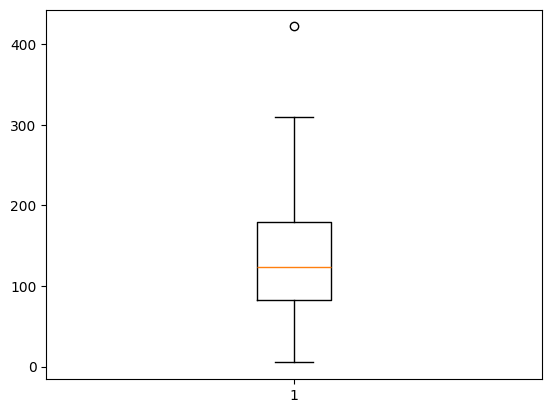

In [ ]:
#visualizing LOE quartiles and outliers via a boxplot
plt.boxplot(df3['loe'])

(array([ 4.,  6.,  0.,  4.,  4.,  6.,  4.,  8.,  4., 15.,  5.,  6.,  6.,
         6.,  7.,  3.,  7.,  3.,  4.,  4.,  3.,  0.,  2.,  1.,  2.,  3.,
         0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([  5.   ,  15.425,  25.85 ,  36.275,  46.7  ,  57.125,  67.55 ,
         77.975,  88.4  ,  98.825, 109.25 , 119.675, 130.1  , 140.525,
        150.95 , 161.375, 171.8  , 182.225, 192.65 , 203.075, 213.5  ,
        223.925, 234.35 , 244.775, 255.2  , 265.625, 276.05 , 286.475,
        296.9  , 307.325, 317.75 , 328.175, 338.6  , 349.025, 359.45 ,
        369.875, 380.3  , 390.725, 401.15 , 411.575, 422.   ]),
 <BarContainer object of 40 artists>)

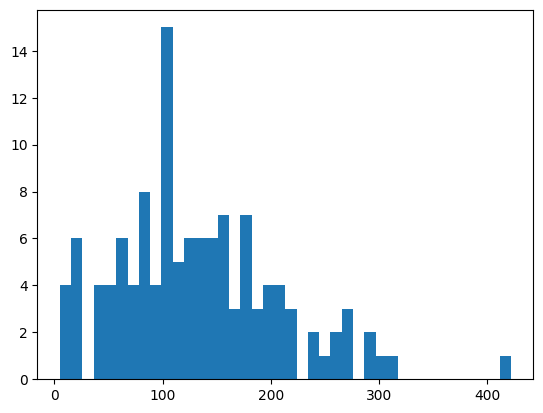

In [ ]:
#visualizing the LOE distruution and density via a histogram
plt.hist(df3['loe'], bins=40)

Looking at the box plot and histogram, we can see that values are more widely spead across the 4th quartile and that they are less frequenet than values in the firt 3 quartiles. After discussing this observation with the subjemt matter experts, they mentioned that it is rare for projects to require LOE higher than 200 and that scuh projects should be treated as outliers and excluded from the analysis.

## Data Modeling

The next step is to establish a baseline performance metric, then continue to experiment with different model and feature variations to arrive at the best combination. Once there, we start tuning the hyperparameters to optimize performance

In [ ]:
# Import ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

#### Define Helper Function

The helper functions below will enable us to consistently perform and re-perform standard operations to model and project model outputs. The three helper funtions below do the following:
- Print histograms
- Calcualte performance metrics
- build models and make predictions

In [ ]:
def print_histograms(error_data, results_dataframe):
    '''
    Plots the predictin error for the model/dataframe combinations in this code. The output is a 5X3 matrix of subplots
    '''
    rows = 5
    cols = 3
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (8,5), sharex=True, sharey = True)
    axes = ax.ravel()
    i = 0
    for d in error_data:
        row = i // 3
        col = i % 3
        ind = (row*cols)+col
        ax[row,col].hist(d, bins=8)
        #sns.histplot(d, kde='true', ax=ax[row,col], bins=10)
        modelname=results_dataframe.loc[ind,'model name']
        dfname=results_dataframe.loc[ind,'df name']
        ax[row,col].title.set_text(f'{modelname} / {dfname}' )
        i += 1

    plt.tight_layout()
    plt.show()

In [ ]:
def calc_metrics(y_true, y_pred):
    '''
    Calculates the out of sample R2, Mean Average Error, and Root Mean Square Error
    '''

    #calculate OSR2
    ORS2 = r2_score(y_true, y_pred)

    #Calcualte MAE
    MAE = mean_absolute_error(y_true, y_pred)

    #Calculate MSE
    MSE = mean_squared_error(y_true, y_pred)

    std_dev = np.std(abs(y_true-y_pred))

    #Print Metrics
    print(f'Out-of-Sample R2: {ORS2:.3f}')
    print(f'Mean Squared Error: {MSE:.3f}')
    print(f'Mean Absolute Error: {MAE:.3f}')
    print(f'Standard Deviation: {std_dev:.3f}')

In [ ]:
def make_predictions(model, dataframe):
    '''
    Takes any number of sklearn models and dataframes and creates predictions using all possible combinations.
    Retruns a pandas dataframe with the results and a list of differences
    '''
    #Create a dataframe to capture the output
    results = pd.DataFrame(columns = ['model name','df name','column combination','r2 score', 'MAE', 'MSE'])

    if type(model) is list and type(dataframe) is list:
        #Create empty lists for differences
        difference = []

        #Iterate through all combinations of models and column combinations
        for test in dataframe:
            X = test.iloc[:,2:]
            y = test.iloc[:,0]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
            for mo in model:
                m = mo.fit(X_train,y_train)
                p = m.predict(X_test)
                difference.append(list(y_test-p))
                new_row = pd.DataFrame({'model name': [type(mo).__name__], 'df name': [test.name], 'column combination': [test.columns.tolist()], 'r2 score':[round(r2_score(y_test,p),3)],'MAE':[round(mean_absolute_error(y_test,p),3)],'MSE':[round(mean_squared_error(y_test,p),3)]})
                results = pd.concat([results,new_row], ignore_index=True)
                df.reset_index()
        return results, difference

    elif type(model) is list:
        #Create empty lists for differences
        difference = []

        #Iterate through all models
        dataframe.dropna(inplace=True)
        X = dataframe.iloc[:,2:]
        y = dataframe.iloc[:,0]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        for mo in model:
            m = mo.fit(X_train,y_train)
            p = m.predict(X_test)
            difference.append(list(y_test-p))
            new_row = pd.DataFrame({'model name': [type(mo).__name__], 'df name': [dataframe.name], 'column combination': [dataframe.columns.tolist()], 'r2 score':[r2_score(y_test,p)],'MAE':[mean_absolute_error(y_test,p)],'MSE':[mean_squared_error(y_test,p)]})
            results = pd.concat([results,new_row], ignore_index=True)
            df.reset_index()
        return results, difference

    elif type(dataframe) is list:
        #Create empty lists for differences
        difference = []

        #Iterate through all dataframes
        for test in dataframe:
            test.dropna(inplace=True)
            X = test.iloc[:,2:]
            y = test.iloc[:,0]
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
            m = model.fit(X_train,y_train)
            p = m.predict(X_test)
            difference.append(list(y_test-p))
            new_row = pd.DataFrame({'model name': [type(model).__name__], 'df name': [test.name], 'column combination': [test.columns.tolist()], 'r2 score':[r2_score(y_test,p)],'MAE':[mean_absolute_error(y_test,p)],'MSE':[mean_squared_error(y_test,p)]})
            results = pd.concat([results,new_row], ignore_index=True)
            df.reset_index()
        return results, difference

    else:
        dataframe.dropna(inplace=True)
        X = dataframe.iloc[:,2:]
        y = dataframe.iloc[:,0]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
        m = model.fit(X_train,y_train)
        p = m.predict(X_test)
        difference = list(y_test-p)
        new_row = pd.DataFrame({'model name': [type(model).__name__], 'df name': [dataframe.name], 'column combination': [dataframe.columns.tolist()], 'r2 score':[r2_score(y_test,p)],'MAE':[mean_absolute_error(y_test,p)],'MSE':[mean_squared_error(y_test,p)]})
        results = pd.concat([results,new_row], ignore_index=True)
        df.reset_index()
        return results, difference



#### Create Dataframe and Model Variations
In this section, we will create mutiple variations of column combinations and predictive models. We will study the performance of those data/model combinations to identify the most promising combination. Then, we will proceed to refine and fine tune that combination to further improve its performance.

In [ ]:
#Creating Different variations of column combinations

#Create a dictionary to host the columns variations:
cols_var_dict = {}

# Determine the base columns. The base columns will be used across all variations:
base_cols = ['loe', 'duration','cluster_Budget & Admin Expenses',
       'cluster_Data Governance and Management', 'cluster_E&S',
       'cluster_External Funds', 'cluster_Fiduciary',
       'cluster_Financial Risks', 'cluster_Human Resources',
       'cluster_IT Systems and Security', 'cluster_Insurance Operations',
       'cluster_Integrity', 'cluster_Internal Justice & Conflict',
       'cluster_Investment Operations', 'cluster_Knowledge Management',
       'cluster_Legal, Corp. Comms, & A2I', 'cluster_Lending Operations',
       'cluster_Procurement & Administration',
       'cluster_Risk & Business Continuity',
       'cluster_Security, Health & Safety, & Real Estate',
       'cluster_Strategy Implementation']

#Create variations of addtional columns to add to the base columns -- Once these columns are added, we will convert them to dummy variables:
variation_cols = [['entity','team', 'business_area'],
                  ['team', 'business_area', 'product_type'],
                  ['entity','team', 'business_area', 'product_type', 'qst', 'qnd'],
                  ['team','qst', 'qnd'],
                  ['entity', 'business_area', 'product_type']]

#Create the different combinations of base and addtional columns:
i=1
for var in variation_cols:
    cols_var_dict[f'test_columns{i}'] = base_cols + var
    i+=1


In [ ]:
cols_var_dict['test_columns1'][len(base_cols):]

['entity', 'team', 'business_area']

In [ ]:
#Get dummies of the addtionl columns for the different column combinations
test_df1 = pd.get_dummies(df3[cols_var_dict['test_columns1']], columns=cols_var_dict['test_columns1'][len(base_cols):], dtype = int)
test_df2 = pd.get_dummies(df3[cols_var_dict['test_columns2']], columns=cols_var_dict['test_columns2'][len(base_cols):], dtype = int)
test_df3 = pd.get_dummies(df3[cols_var_dict['test_columns3']], columns=cols_var_dict['test_columns3'][len(base_cols):], dtype = int)
test_df4 = pd.get_dummies(df3[cols_var_dict['test_columns4']], columns=cols_var_dict['test_columns4'][len(base_cols):], dtype = int)
test_df5 = pd.get_dummies(df3[cols_var_dict['test_columns5']], columns=cols_var_dict['test_columns5'][len(base_cols):], dtype = int)

#assign a name for each dataframe to include as an identifier later in the code
test_df1.name = 'test_df1'
test_df2.name = 'test_df2'
test_df3.name = 'test_df3'
test_df4.name = 'test_df4'
test_df5.name = 'test_df5'

In [ ]:
#Initiate Different Regression models:
regression_tree = DecisionTreeRegressor(random_state=42)
random_forest_regressor = RandomForestRegressor(random_state=42)
linear_regression = LinearRegression()

In [ ]:
#Create lists of models and data variations to iterate through
test_data_all = [test_df1, test_df2, test_df3, test_df4, test_df5]
models = [regression_tree, random_forest_regressor, linear_regression]

We pass the different combinations of dataframe variations and regression models to the prediction helper funciton

In [ ]:
#Use the data/model combinations to make predictions
result, difference = make_predictions(models, test_data_all)

After making the predictions, we plot the residuals for those combinations and observe the difference.  

We can see that the residuals for the tree regressors more closely resemble a normal distribution. one possible explaination is that the relationship in the data is not linear.  Of the tree models, the rendom forest regressor seem to have more consistent resemeblence of a normal distribution. This gives us some confidence that random forest is able to capture the main patterns and sources of variation in the data.

for the rest of the notebook , we will be using test_df3 since it has all of our columns and will, therefore, give us the flexiblity to test different scenarios.

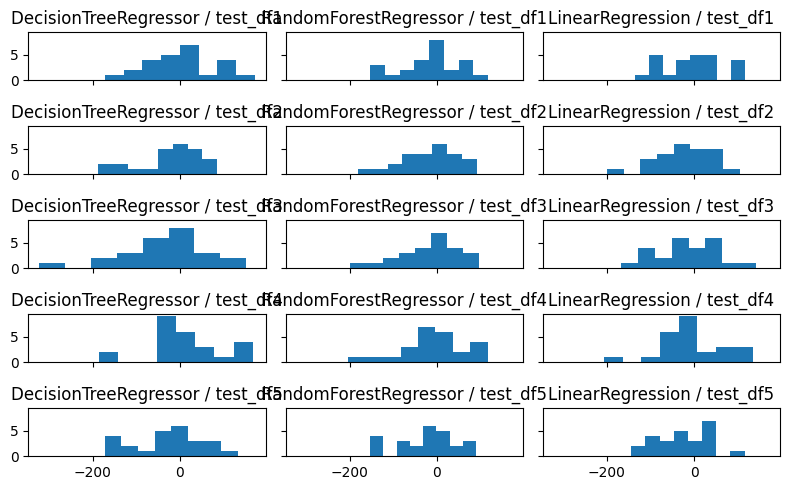

In [ ]:
#Plot the residuals for the different combinations and examine their spread
print_histograms(difference, result)

Even though the residuals for the random forest models are normally distributed, the R2 values are quite low, meaing the models are not yet able to explain the variance in the data. It could be that outliers, high variance, or skewness in the data are hurting the performance of the models.


In [ ]:
result.sort_values(by = 'r2 score', ascending= False).loc[:,result.columns != 'column combination']

,model name,df name,r2 score,MAE,MSE
14,LinearRegression,test_df5,0.099,53.167,4355.382
2,LinearRegression,test_df1,0.037,53.852,4654.930
4,RandomForestRegressor,test_df2,0.019,52.910,4739.666
1,RandomForestRegressor,test_df1,0.007,51.153,4798.191
5,LinearRegression,test_df2,0.001,54.634,4829.470
8,LinearRegression,test_df3,-0.029,56.335,4971.464
7,RandomForestRegressor,test_df3,-0.051,52.025,5080.762
10,RandomForestRegressor,test_df4,-0.056,53.192,5101.075
11,LinearRegression,test_df4,-0.149,56.041,5552.379
13,RandomForestRegressor,test_df5,-0.156,56.572,5586.745


### Check for dispersion, skewness, and outliers in the data

Since imbalances can negatively impact the performance of our models, we will examine our dependat variable to better udnerstand its behavior: we will check how dispersed it is around the mean, whether it is skewed or has kurtosis, and and it has outliers. To achieve that, we will calcualte the coefficient of variance (CV), run a kde plot, and boxplot, respectively.

a general rule of thumb to interpret CV is as follows:

- less than 10%: low dispersion, suggesting the data points are clustered around the mean
- between 10% and 20%: moderate dispersion, data points are spread out to some extent
- more than 20%: high dispersion, suggesting high variability in the data



#### Coefficient of Variance (CV)

We can see that CV for LOE is close to 60%, indicating high variability in the data.

In [ ]:
# Calcualte Coefficient of Variance:

cof_var = test_df3['loe'].std() / test_df3['loe'].mean()
print(f'{cof_var:.2f}')

0.57


#### Check for outliers

examining the boxpot below, we can see outliers where the LOE is extermely high

{'whiskers': [<matplotlib.lines.Line2D at 0x79e3d1402750>,
 'caps': [<matplotlib.lines.Line2D at 0x79e3d1403990>,
 'boxes': [<matplotlib.lines.Line2D at 0x79e3d16daad0>],
 'medians': [<matplotlib.lines.Line2D at 0x79e3d1410c90>],
 'fliers': [<matplotlib.lines.Line2D at 0x79e3d14115d0>],
 'means': []}

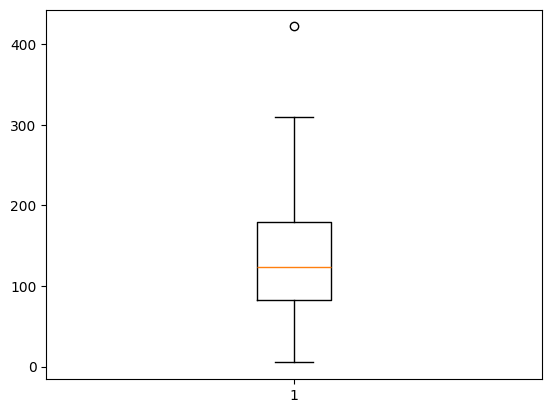

In [ ]:
plt.boxplot(test_df3['loe'])

After closely examining the data, we can confidently conclude that it is imbalanced. We can fix the imbalance by either removing outliers, or resampling the data to balance the distribution

### Over/Under Sampling of Data to Balance the Dataset
Since our Data is unbalanced, any model we develop will stuggle to gerenlize on the underrepresented sub-populatuions. As a result, the overall accuracy of the model suffers.

In order to fix this, we will need to resample the data to balance the represenation.  Using the SMOGN library is a good idea to over sample the miniority values and undersample the majority values.

SMOGN library, or Synthetic Minority Over-Sampling Technique for Regression with Gaussian Noise, is a Python library designed to handle imbalanced regression problems. This means it helps when you have a regression task where some values of the target variable are rare or uncommon in your dataset

[Clcik here for more details on SMOGN](https://pypi.org/project/smogn/)

In [ ]:
!pip install smogn

In [ ]:
import smogn

In [ ]:
'''
rg_mtrx = [

    [35000,  1, 0],  ## over-sample ("minority")
    [125000, 0, 0],  ## under-sample ("majority")
    [200000, 0, 0],  ## under-sample
    [250000, 0, 0],  ## under-sample
]
'''

'\nrg_mtrx = [\n\n    [35000,  1, 0],  ## over-sample ("minority")\n    [125000, 0, 0],  ## under-sample ("majority")\n    [200000, 0, 0],  ## under-sample\n    [250000, 0, 0],  ## under-sample\n]\n'

r_index: 100%|##########| 23/23 [00:00<00:00, 200.40it/s]


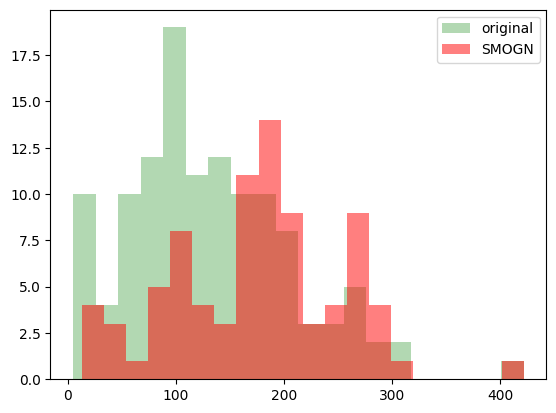

In [ ]:
#Create initial balanced dataset and plot to see difference - USING THE TEST DATAFRAME WITH THE HIGHSET NUMBER OF COLUMNS
df_smogn0 = smogn.smoter(data = test_df3, y = 'loe', k=7, samp_method='balance', rel_thres = 0.10, pert = 0.05)
plt.hist(test_df3['loe'], bins=20, alpha = 0.3, label='original', color = 'g')
plt.hist(df_smogn0['loe'], bins=20, alpha = 0.5, label='SMOGN', color = 'r')
plt.legend()
plt.show()

In [ ]:
#Create different variations of balaneced datasets to see difference
df_smogn0 = smogn.smoter(data = test_df3, y = 'loe', k=7, samp_method='balance', rel_thres = 0.10, pert = 0.05)
df_smogn1 = smogn.smoter(data = test_df3, y = 'loe', k=7, samp_method='extreme', rel_thres = 0.10, pert = 0.05)
df_smogn2 = smogn.smoter(data = test_df3, y = 'loe', k=10, samp_method='balance', rel_thres = 0.10, pert = 0.05)
df_smogn3 = smogn.smoter(data = test_df3, y = 'loe', k=10, samp_method='extreme', rel_thres = 0.10, pert = 0.05)

#Rename them for printing later on
df_smogn0.name = 'df_smogn0'
df_smogn1.name = 'df_smogn1'
df_smogn2.name = 'df_smogn2'
df_smogn3.name = 'df_smogn3'

r_index: 100%|##########| 7/7 [00:00<00:00, 183.22it/s]


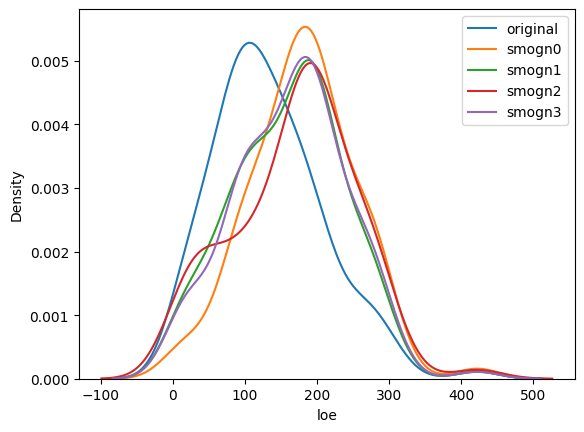

In [ ]:
#Plot the new dataframes
test_data_all = [df_smogn0,df_smogn1,df_smogn2,df_smogn3]

sns.kdeplot(test_df3['loe'], label = 'original')
i = 0
for test in test_data_all:
    sns.kdeplot(test['loe'], label = f'smogn{i}')
    i+=1

plt.legend()
plt.show()

In [ ]:
#Create new lists of datasets and models to use in the function 'make_predictions'
test_data_all = [df_smogn0,df_smogn1,df_smogn2,df_smogn3]
models = [regression_tree, random_forest_regressor, linear_regression]

In [ ]:
# Run predictions on the new datasets and models
result, difference = make_predictions(models, test_data_all)

In [ ]:
result.sort_values(by = 'r2 score', ascending= False)[['model name', 'df name', 'r2 score', 'MAE', 'MSE']]

,model name,df name,r2 score,MAE,MSE
6,DecisionTreeRegressor,df_smogn2,0.455,38.148,2739.300
1,RandomForestRegressor,df_smogn0,0.401,37.253,2528.847
7,RandomForestRegressor,df_smogn2,0.304,48.135,3498.280
10,RandomForestRegressor,df_smogn3,0.024,52.953,4718.314
8,LinearRegression,df_smogn2,-0.275,66.444,6408.326
11,LinearRegression,df_smogn3,-0.317,65.065,6371.700
0,DecisionTreeRegressor,df_smogn0,-0.408,57.910,5941.193
4,RandomForestRegressor,df_smogn1,-1.045,67.497,6706.675
9,DecisionTreeRegressor,df_smogn3,-1.232,75.935,10794.484
5,LinearRegression,df_smogn1,-1.816,78.253,9235.731


Using syntethic data to solve the imbalance in the data, **we were able to get a model with an out of sample R2 of 45%**, representing a **4-fold improvement** on the best performance we had been able to get using the original imbalanced dataset.